In [28]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
LW=5 # linewidth
MS=10 # markersize

g = 9.81 # [m/s2] freefall accerleration 
qc = 0.1
Dt = 0.01 # time step
Nsims = 500 # number of timesteps

This file is based on the class materials of AEROSP 567 taught by Prof. Alex Gorodetsky at University of Michigan. Author: Hung-Hsiang Liang

## Demo of Extended Kalman Filter, Unscented Kalman Filter, and Gauss-Hermite Kalman Filter with Pendulum Model
This file demostrate the implementation of Extended Kalman Filter, Unscented Kalman Filter, and Gauss-Hermite Kalman Filter. These filters are used to fuse measurement data with the pendulum model.


## The Pendulum Model and the Extended Kalman Filter (ExKF)
#### Model
The time-discretized dynamics of a pendulum two states, angle $x_1$ and angular rate $x_2$, where only the angle is measured every $\delta$ timesteps:

\begin{equation}\label{eqn:model}
    \begin{bmatrix}
        x_1^{k+1}\\
        x_2^{k+1}
    \end{bmatrix}
    =
    \begin{bmatrix}
        x_1^k + x_2^k \Delta t \\
        x_2^k - g\sin{(x_1^k)} \Delta t
    \end{bmatrix}
    + \mathbf{q}^k
    = \Phi(\mathbf{X_k}) + \mathbf{q}^k
\end{equation}

and the measurements are described as follows:

\begin{equation}\label{eqn:measurement}
    y^{\delta k} = \sin{(x_1^{\delta k})} + r^{\delta k}
\end{equation}

with $\mathbf{q}^k \sim N(0, \mathbf{Q})$ and $r^{\delta k} \sim N(0, R)$ where

\begin{equation}
    \mathbf{Q} = 
    \begin{bmatrix}
        \frac{q^c \Delta t^3}{3} & \frac{q^c \Delta t^2}{2} \\
        \frac{q^c \Delta t^2}{2} & q^c \Delta t
    \end{bmatrix}
\end{equation}

$q^c = 0.1$, $\Delta t = 0.01$, and the initial condition $(x_1^0, x_2^0) = (1.5, 0)$ are also used here.


#### Extended Kalman Filter (ExKF)
The equations listed in the previous section are the Kalman filter equations of this nonlinear system. To linearize it, we can approximate it with Taylor's series, which leads to Extended Kalman filtering equations:

\begin{equation}
    \Phi(\mathbf{X_{k-1}}) = \Phi(m_{k-1}) + A_k(\mathbf{X_k} - m_{k-1}) + H.O.T
\end{equation}

\begin{equation}
    h(\mathbf{X_k}) = h(m_k^-) + H_k (\mathbf{X_k} - m_k^-) + H.O.T
\end{equation}

here, $A_k$ and $H_k$ are the gradients (Jacobians) of $\mathbf{\Phi}$ and $\mathbf{h}$:

\begin{equation}
    A_k = \nabla \Phi(\mathbf{X_k})|_{X_k = m_{k-1}} =
    \begin{bmatrix}
        \frac{\partial f_1}{\partial x_1^k} & \frac{\partial f_1}{\partial x_2^k} \\
        \frac{\partial f_2}{\partial x_1^k} & \frac{\partial f_2}{\partial x_2^k}
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & \Delta t\\
        -g\cos{(x_1^k)} \Delta t & 1
    \end{bmatrix}
\end{equation}

\begin{equation}
    H_k = \nabla h(\mathbf{X_k})|_{X_k = m_{k-1}} = 
    \begin{bmatrix}
    \frac{\partial h}{\partial x_1^k} & \frac{\partial h}{\partial x_2^k}
    \end{bmatrix}
    =
    \begin{bmatrix}
        \cos{(x_1^{\delta k})} & 0
    \end{bmatrix}
\end{equation}


The integrals for <b>prediction step</b> are:

\begin{align*}
    m_k^- &= \mathbb{E} \left[ X_k|\mathcal{Y}_{k-1} \right] = \int{\Phi (X_{k-1}) \mathcal{N}(X_{k-1}; m_{k-1}, C_{k-1}) dX_{k-1}}\\
            &= \mathbb{E}[\Phi(X_{k-1} + q^k|\mathcal{Y}_{k-1}]\\
            &\approx \mathbb{E}[\Phi(m_{k-1}) + A_k(X_k - m_{k-1})] = \mathbb{E}[\Phi(m_{k-1})] + \mathbb{E}[A_k(X_k - m_{k-1})] =\Phi(m_{k-1}) + A(\mathbb{E}[X_k] - m_{k-1})\\
          &= \Phi(m_{k-1}) \\
    C_{k}^- &= \mathbb{C}ov \left[X_k, X_k|\mathcal{Y}_{k-1} \right] \\
            &= \int{(\Phi(X_{k-1})-m_k^-) (\Phi(X_{k-1})-m_k^-)^T \mathcal{N}(X_{k-1}; m_{k-1}, C_{k-1}) dX_{k-1}} + \mathbf{Q} \\
            &= \mathbb{C}ov [\Phi(X_{k-1}) + q^k, \Phi(X_{k-1}) + q^k|\mathcal{Y}_{k-1}]\\
            &\approx \mathbb{C}ov[\Phi(m_{k-1}) + A_k(X_k - m_{k-1}) + \mathbf{Q}, \Phi(m_{k-1}) + A_k(X_k - m_{k-1}) + \mathbf{Q}| \mathcal{Y}_{k-1}] + \mathbf{Q}\\
            &= A_k C_{k-1} A_k^T + \mathbf{Q}
\end{align*}


The integrals for <b>update step</b> are:
\begin{align*} 
    \mu &= \mathbb{E}[Y_k] = \int{h(X_k) \mathcal{N}(X_k; m_k^-, c_k^-) dX_k}\\
        &= \mathbb{E}[h(X_k) + r^{\delta k}]\\
        &\approx \mathbb{E}[h(m_k^-) + H_k(X_k - m_k^-)]\\
        &= h(m_k^-)\\
    U &= \mathbb{C}ov \left[X_k, Y_k \right] = \int{(X_k - m_k^-)(h(X_k) - \mu)^T \mathcal{N}(X_k; m_k^-, C_k^-)dX_k}\\
      &= \mathbb{C}ov \left[X_k, h(X_k) + r^{\delta k} \right] \\
      &\approx \mathbb{C}ov \left[X_k, h(m_k^-) + H_k (X_k - m_k^-) \right] \\
      &= C_k^- H_k^T\\
    S &= \mathbb{C}ov [Y_k, Y_k] = \int{(h(X_k)-\mu)(h(X_k) - \mu)^T \mathcal{N}(X_k; m_k^-, C_k^-)dX_k} + R\\
      &= \mathbb{C}ov[h(X_k) + r^{\delta k}, h(X_k) + r^{\delta k}] \\
      &= \mathbb{C}ov[h(X_k), h(X_k)] + R\\
      &\approx \mathbb{C}ov[h(X_k) + H_k (X_k - m_k^-), h(X_k) + H_k (X_k - m_k^-)] + R \\
      &= H_k C_k^- H_k^T + R\\
    m_k &= m_k^- + US^{-1}(y_k - \mu)\\
    C_k &= C_k^- - US^{-1}U^T\\
\end{align*}

#### Analytical Solution
For analytical solution, we can rewrite $\mu$ as follows:
\begin{equation}
    \mu = \int{h(X_k) \mathcal{N}(X_k; m_k^-, c_k^-) dX_k}
\end{equation}
plugging $h(X_k) = \sin{x_1}$ and replacing $\mathcal{N}(X_k; m_k^-, c_k^-)$ with normal distribution formula, we have

\begin{equation}
    \mu = \int{\int{ \sin{x_1}  \frac{ exp \left( -0.5(X_k - m_k^-)^T C_k^{-1} (X_k - m_k^-) \right)} {\sqrt{(2\pi)^2|C_k|}} dx_1}dx_2}\\
\end{equation}
Set $z_1 = x_1 - m_{(k, 1)}^-$, $z_2 = x_2 - m_{(k, 2)}^-$ and $dz_1 = dx_1$, $dz_2 = dx_2$
\begin{align*}
    \mu &= \int{\int{ \frac{\sin{(z_1 + m_{(k, 1)}^-)}}{\sqrt{(2\pi)^2|C_k|}} \exp \left( {-0.5 \sum_{i,j=1}^{2} (C_k^-)_{ij}^{-1} z_i z_j} \right) dz_1}dz_2} \\
    &= \exp\left(0.5 \sum_{i,j=1}^{2} (C_k^-)_{ij} \frac{\partial}{\partial z_i}\frac{\partial}{\partial z_j}\right)\sin{(z_1 + m_{(k, 1)}^-)}|_{z = 0}
\end{align*}
the integration above is achieved using Gaussian integration formula. Computing the partial derivatives, obtain
\begin{equation}
    \mu = \exp\left(-0.5 (C_k^-)_{11} \right) \sin{(m_{(k, 1)}^-)}
\end{equation}

#### ExKF Prediction Step

In [1]:
def prediction_step(Phi, A, mean, cov, noise_cov):
    """Prediction Step: Propagate uncertainty for one time step

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{0, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    Phi: callable, non-linear system
    A: callable, first order term of Taylor series (Gradient of Phi)
    mean: (d, ) prior mean
    cov: (d, d) prior covariance, symmetric positive definite
    noise_cov: (d, d) process noise covariance, symmetric positive definite

    Returns
    -------
    pred_mean: (d, ) predicted mean
    pred_cov: (d, d) predicted covariance
    """
    
    pred_mean = Phi(mean)
    pred_cov = np.dot(A(mean), np.dot(cov, A(mean).T)) + noise_cov
    
    return pred_mean, pred_cov

#### ExKF Update Step

In [30]:
def update_step(data, h, H, mean, cov, noise_cov):
    """Update Step
    
    Inputs
    ------
    data: (d,)
    h: callable, measurement function
    H: callable first order term of Taylor series (Gradient of h)
    mean: (d) prior mean
    cov: (d, d) prior covariance
    noise_cov : (d, d) noise covariance matrix
    
    Returns
    -------
    update_mean: (d, ) updated mean
    update_cov: (d, d) updated covariance
    
    """

    mu = h(mean)
    H_mean = H(mean)
    U = np.dot(cov, H_mean.T)
    S = np.dot(H_mean, np.dot(cov, H_mean.T)) + noise_cov
    update_mean = mean[:, np.newaxis] + np.dot(U, np.linalg.inv(S)) * (data[0] - mu[0])
    update_mean = np.reshape(update_mean, 2)
    update_cov = cov - np.dot(U, np.linalg.solve(S, U.T))
    
    return update_mean, update_cov

#### ExKF routine

In [31]:
def extended_kalman_filter(data, Phi, A, proc_cov, h, H, meas_cov, prior_mean, prior_cov):
    """The Extended Kalman filter
    
    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    Phi: callable, non-linear system
    A: callable, first order term of Taylor series (Gradient of Phi)
    proc_cov: (d,d), process noise covariance
    h: callable, measurement function
    H: callable, first order term of Taylor series (Gradient of h)
    meas_cov: (m, m), measurement noise covariance
    prior_mean: (d, ) prior mean
    prior_cov: (d, d), prior_covariance
    
    Return
    ------
    mean_store: (N+1, d): posterior means (first row is the prior)
    cov_store: (d, d, N+1): posterior covariances (first block is the prior)    
    """
    
    d = prior_mean.shape[0]
    N = data.shape[0]
    m = data.shape[1]
    
    mean_store = np.zeros((N+1, d))
    mean_store[0, :] = np.copy(prior_mean)
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    #Loop over all data
    for ii in range(N):
        # Prediction
        pred_mean, pred_cov = prediction_step(Phi, A, mean_store[ii, :], cov_store[:, :, ii], proc_cov)

        # Update
        if ii % delta != 0:
            mean_store[ii+1, :] = pred_mean
            cov_store[:, :, ii+1] = pred_cov
        elif ii % delta == 0:
            mean_store[ii+1, :], cov_store[:, :, ii+1] = update_step(data[ii, :], h, H, pred_mean, pred_cov, meas_cov)
        
    return mean_store, cov_store

#### $\Phi(\mathbf{X})$ Function
\begin{equation}
    \Phi(\mathbf{X}) = 
    \begin{bmatrix}
        f_1(\mathbf{X}) \\
        f_2(\mathbf{X})
    \end{bmatrix}
    =
    \begin{bmatrix}
        x_1^k + x_2^k \Delta t \\
        x_2^k - g\sin{(x_1^k)} \Delta t
    \end{bmatrix}
\end{equation}

In [32]:
def Phi(X):
    '''
    Dynamic model
    ---------------------
    inputs:
    X: (d), states
    ---------------------
    outputs:
    X_next: (N, d), next states
    '''
    
    X_next = X.copy()
    X_next[0] = X[0] + X[1] * Dt
    X_next[1] = X[1] - g * np.sin(X[0]) * Dt
    
    return X_next

####  $\nabla \Phi$ Function

\begin{equation}
    A_k = \nabla \Phi(\mathbf{X}) = 
    \begin{bmatrix}
        \frac{\partial f_1}{\partial x_1^k} & \frac{\partial f_1}{\partial x_2^k} \\
        \frac{\partial f_2}{\partial x_1^k} & \frac{\partial f_2}{\partial x_2^k}
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & \Delta t\\
        -g\cos{(x_1^k)} \Delta t & 1
    \end{bmatrix}
\end{equation}

In [33]:
def grad_Phi(X):
    '''
    Gradient of Dynamic model
    ---------------------
    inputs:
    X: (d), states
    ---------------------
    outputs:
    grad_X (d, d), gradient (Jacobian) of Phi
    '''
    d = X.shape[0]
    grad_X = np.ones((d, d))
    grad_X[0, 1] = Dt
    grad_X[1, 0] = -g * np.cos(X[0]) * Dt
    
    return grad_X

#### $h(\mathbf{X})$ Function

\begin{equation}
    y^{\delta k} = \sin{(x_1^{\delta k})} + r^{\delta k}
\end{equation}
where $r^{\delta k } \sim N(0, R)$

In [34]:
def h(X):
    '''
    Measurement function
    ---------------------
    inputs:
    X: (d), states
    ---------------------
    outputs:
    y: (1,), measurement outputs
    '''
    y = np.copy(X)
    y[0] = np.sin(X[0])
    y[1] = 0
    
    return y 

#### $ \nabla h(\mathbf{X})$ Function

\begin{equation}
    H_k = \nabla h(\mathbf{X}) = 
    \begin{bmatrix}
        \cos{(x_1^{\delta k})} & 0
    \end{bmatrix}
\end{equation}

In [35]:
def grad_h(X):
    '''
    Gradient of Measurement function
    ---------------------
    inputs:
    X: (d), states
    ---------------------
    outputs:
    y: (1, 1), gradient (Jacobian) of measurement function
    '''
    
    grad_h = np.array([[np.cos(X[0]), 0]])
    
    return grad_h

#### Generate the truth for the second-order system

In [36]:
def generate_truth(N, x0, h, Phi, noise_std=1e-2):
    """Generate the truth for the second-order system"""
    
    xout = np.zeros((N+1, 2)) 
    
    Phi_X = Phi(xout[0, :])
    h_X = h(xout[0, :])
    yout = np.zeros((N, 2))
    xout[0, :] = x0
    
    for ii in range(N):
        xout[ii+1, :] = Phi(xout[ii, :])
        if ii%delta == 0:
            yout[ii, :] = h(xout[ii+1, :]) + noise_std * np.random.randn(1)
            yout[ii, 1] = 0
        else:
            yout[ii, :] = np.copy(yout[ii-1, :])
    return xout, yout

#### Get square root of diagonals (standard deviations) from covariances

In [37]:
def get_std(cov):
    """Get square root of diagonals (standard deviations) from covariances """
    
    d, d, N = cov.shape
    std_devs = np.zeros((N, d))
    for ii in range(N):
        std_devs[ii, :] = np.sqrt(np.diag(cov[:, :, ii]))
    return std_devs


#### Run ExKF Filtering

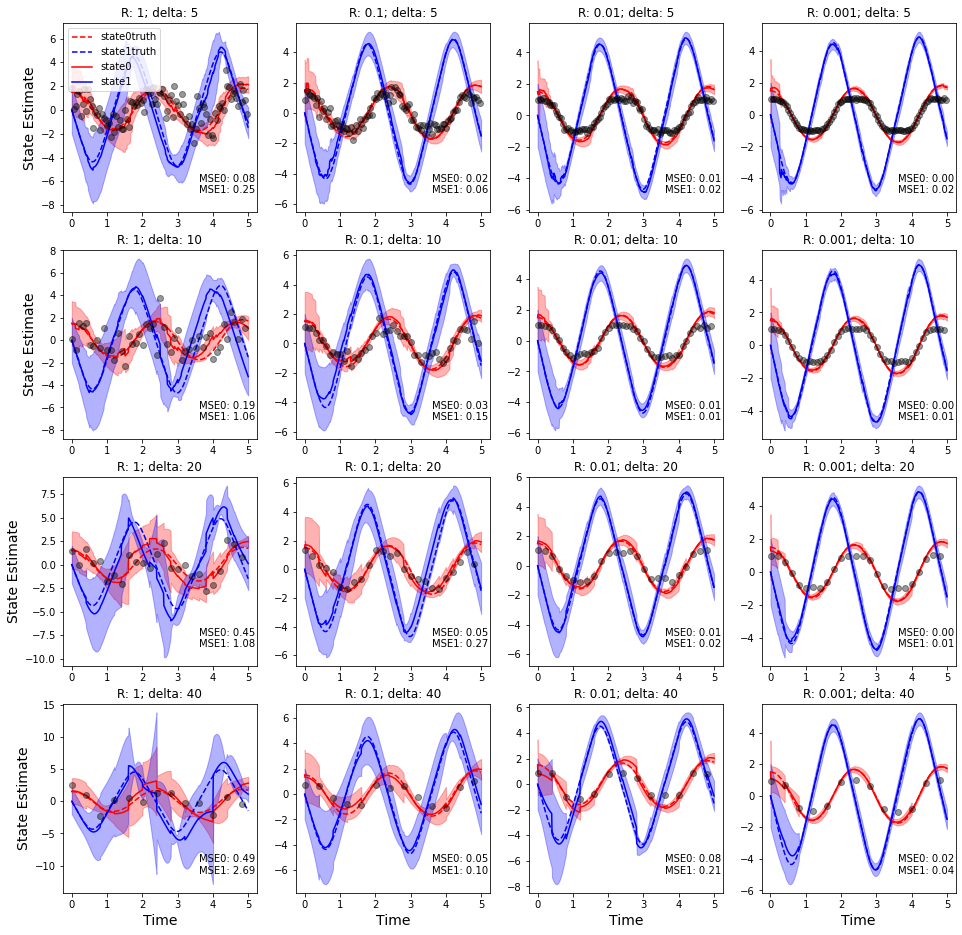

In [60]:
ExKF_mean_post = np.zeros((16, Nsims+1, 2))
ExKF_cov_post = np.zeros((16, 2, 2, Nsims+1))

plt.figure(figsize=(16,16))

i = 1
t = np.linspace(0, Dt*Nsims, Nsims+1)

for delta in [5, 10, 20, 40]:
    for R in [1, 0.1, 0.01, 0.001]:
        ax = plt.subplot(4, 4, i)
        
        x0 = np.array([1.5, 0])
        xout, yout = generate_truth(Nsims, x0, h, Phi, noise_std=np.sqrt(R))
        
        prior_mean = np.copy(x0) # prior mean
        prior_cov = np.eye(2)  # prior covariance
        proc_cov = np.array([[qc * (Dt)**3 / 3, qc * (Dt)**2 / 2], [qc * (Dt)**2 / 2, qc * (Dt)]])
        meas_cov = np.copy(R)
        
        meanpost, covpost = extended_kalman_filter(yout, Phi, grad_Phi, proc_cov, h, grad_h, meas_cov, prior_mean, prior_cov)
        ExKF_mean_post[i-1, :, :] = meanpost
        ExKF_cov_post[i-1, :, :, :] = covpost
        
        std_devs = get_std(covpost) #extract the standard deviations at all the states
        
        ax.plot(t, xout[:, 0],'--', color='red', label='state0truth')
        ax.plot(t, xout[:, 1],'--', color='blue', label='state1truth')

        ax.plot(t, meanpost[:, 0], color='red', label='state0')
        ax.plot(t, meanpost[:, 1], color='blue', label='state1') 
        ax.fill_between(t, meanpost[:, 0] - 2 * std_devs[:, 0],  meanpost[:, 0] + 2*std_devs[:, 0],
                        color='red', alpha=0.3)
        ax.fill_between(t, meanpost[:, 1] - 2 * std_devs[:, 1],  meanpost[:, 1] + 2*std_devs[:, 1],
                        color='blue', alpha=0.3)
        
        MSE0 = np.sum((meanpost[:, 0] - xout[:, 0])**2)/Nsims##
        MSE1 = np.sum((meanpost[:, 1] - xout[:, 1])**2)/Nsims##
        tex = "MSE0: {:.2f}\nMSE1: {:.2f}".format(MSE0, MSE1) 
        ax.text(0.7, 0.1, tex, transform=ax.transAxes)
        
        for ii in range(1, Nsims+1, delta):
            plt.plot(t[ii], yout[ii, 0], 'ko', alpha=0.4)
            
        if R==1 and delta==5:##
            ax.legend(loc=2)##
        
        if delta==40:
            ax.set_xlabel('Time', fontsize=14)
        
        if R==1:
            ax.set_ylabel('State Estimate',fontsize=14)
            
        ax.set_title('R: ' + str(R) + '; delta: ' + str(delta))
        
        i += 1
        
plt.show()

## Unscented Kalman Filter (UKF)

The goal of this algorithm is to approximate the following integral:
\begin{equation}\label{eqn:UKF_Int}
    \int{h(X) \mathcal{N}(X|\mu, \Sigma) dX}
\end{equation}
We first define a scaling parameter which indicates how far the quadrature points are spread:
\begin{equation}
    \lambda = \alpha^2(d + \kappa) - d
\end{equation}
$\lambda$ is used to define the quadrature points:
\begin{equation}
    u^{(i)} = \sqrt{d + \lambda} \hat{u}^{(i)}, \forall \hat{u}^{(i)} \in [\mathbf{M}]
\end{equation}
where $[\mathbf{M}]$ is defined as:

\begin{align*}
    [\mathbf{M}] &=
    \begin{bmatrix}
        u^{(0)}, u^{(1)}, u^{(2)}, ..., u^{(d)}, u^{(d+1)}, u^{(d+2)}, ..., u^{(2d)}
    \end{bmatrix}\\
    &=
    \begin{bmatrix}
        \begin{pmatrix} 0 \\ 0 \\ 0 \\.\\.\\.\\0 \end{pmatrix},
        \begin{pmatrix} 1 \\ 0 \\ 0 \\.\\.\\.\\0 \end{pmatrix},
        \begin{pmatrix} 0 \\ 1 \\ 0 \\.\\.\\.\\0 \end{pmatrix},
        ...
        \begin{pmatrix} 0 \\ 0 \\ 0 \\.\\.\\.\\1 \end{pmatrix},
        \begin{pmatrix} -1 \\ 0 \\ 0 \\.\\.\\.\\0 \end{pmatrix},
        \begin{pmatrix} 0 \\ -1 \\ 0 \\.\\.\\.\\0 \end{pmatrix},
        ...
        \begin{pmatrix} 0 \\ 0 \\ 0 \\.\\.\\.\\-1 \end{pmatrix},
    \end{bmatrix}
\end{align*}

with $d$ being the dimension of states. The weights used for the means are
\begin{equation}
    w_m^{(i)} = 
    \begin{cases}
        \frac{\lambda}{d + \lambda} & i = 0\\
        \frac{1}{2(d+\lambda)} & i = 1, 2, ..., 2d
    \end{cases}
\end{equation}
meanwhile, the weights used for covariances are:
\begin{equation}
    w_c^{(i)} = 
    \begin{cases}
        \frac{\lambda}{d + \lambda} + (1 - \alpha^2 + \beta )& i = 0\\
        \frac{1}{2(d+\lambda)} & i = 1, 2, ..., 2d
    \end{cases}
\end{equation}
where $\alpha$, $\beta$, and $\kappa$ are free parameters. In this project, $(\alpha=1, \beta=0, \kappa=0)$ is used.

Together with sigma points, 
\begin{equation}
    \mu + \sqrt{\Sigma(d+\lambda)} \hat{u}^{(i)}
\end{equation}
the first integral of this section can be approximated as:
\begin{equation}
    \int{h(X) \mathcal{N}(X|\mu, \Sigma) dX}
    \approx
    \sum^{2d}_{i=0} h(\mu + \sqrt{\Sigma(d+\lambda)} \hat{u}^{(i)})w^{(i)}
\end{equation}

#### Unscented Points (Sigma Points) Generation

In [61]:
def unscented_points(mean, cov, alg='chol', alpha=1, beta=0, kappa=0):
    """Generate unscented points"""    
    dim = cov.shape[0]
    lam = alpha*alpha*(dim + kappa) - dim
    if alg == "chol":
        L = np.linalg.cholesky(cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(cov)
        L = np.dot(u, np.sqrt(np.diag(s)))
    pts = np.zeros((2*dim+1, 2))
    pts[0, :] = mean
    for ii in range(1, dim+1):        
        pts[ii, :] = mean + np.sqrt(dim + lam)*L[:, ii-1]        
        pts[ii+dim,:] = mean - np.sqrt(dim + lam)*L[:, ii-1]

    W0m = lam / (dim + lam)
    W0C = lam / (dim + lam) + (1 - alpha*alpha + beta)
    Wim = 1/2 / (dim + lam)
    Wic = 1/2 / (dim + lam)
    return pts, (W0m, Wim, W0C, Wic)

#### UKF Algorithm: Prediction Step
The sigma points are generated based on previous step $X_{k-1}$ and previous covariance $C_{k-1}$:
\begin{equation}
    X_{k-1}^{(i, \sigma)} = X_{k-1} + \sqrt{C_{k-1}(d+\lambda)} \hat{u}^{(i)}
\end{equation}
we have 
\begin{equation}
    m_k^- = \sum_{i=0}^{2d} w_m^{(i)} \Phi(X_{k-1}^{(i, \sigma)})
\end{equation}
and
\begin{equation}
    C_k^- = \sum_{i=0}^{2d}w_c^{(i)}[\Phi(X_{k-1}^{(i, \sigma)}) - m_k^-][\Phi(X_{k-1}^{(i, \sigma)}) - m_k^-].^T + \mathbf{Q}
\end{equation}

In [62]:
def unscented_prediction_step(Phi, mean, cov, noise_cov, UP, W):
    """Prediction Step (UKF): Propagate uncertainty for one time step using unscented Kalman Filter

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{0, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    Phi: callable, non-linear system
    mean: (d, ) prior mean
    cov: (d, d) prior covariance, symmetric positive definite
    noise_cov: (d, d) process noise covariance, symmetric positive definite
    UP: unscented points
    W: weights

    Returns
    -------
    pred_mean: (d, ) predicted mean
    pred_cov: (d, d) predicted covariance
    UP_Phi: Phi of Unscented Points
    """
    dim = cov.shape[0]
    UP_Phi = np.zeros((2*dim + 1, 2)) # Phi of sigma points 
    pred_mean = np.zeros((2))
    
    pred_mean = W[0] * Phi(UP[0, :])
    for ii in range(1, 2*dim + 1):        
        UP_Phi[ii, :] = Phi(UP[ii, :])
        pred_mean += W[1] * UP_Phi[ii, :]
    
    delta = UP_Phi - pred_mean
    
    pred_cov = W[2] * np.dot(delta[0, :][:, np.newaxis], delta[0, :][np.newaxis, :])
    for ii in range(1, 2*dim + 1):
        pred_cov += W[3] * np.dot(delta[ii, :][:, np.newaxis], delta[ii, :][np.newaxis, :])
    pred_cov += noise_cov
    
    return pred_mean, pred_cov, UP_Phi

#### UKF Algorithm: Update Step

\begin{equation}
    \mu = \sum_{i=0}^{2d}w_m^{(i)} h(\Phi(X_{k-1}^{(i, \sigma)}))
\end{equation}
\begin{equation}
    U = \sum_{i=0}^{2d}w_c^{(i)}[\Phi(X_{k-1}^{(i, \sigma)}) - m_k^-][h(\Phi(X_{k-1}^{(i, \sigma)})) - \mu]^T
\end{equation}
\begin{equation}
    S = \sum_{i=0}^{2d}w_c^{(i)}[h(\Phi(X_{k-1}^{(i, \sigma)})) - \mu][h(\Phi(X_{k-1}^{(i, \sigma)})) - \mu]^T + r^{\delta k}
\end{equation}
\begin{equation}
    m_k = m_k^- + US^{-1}(y_k - \mu)
\end{equation}
\begin{equation}
    C_k = C_k^- - US^{-1}U^T
\end{equation}

In [63]:
def unscented_update_step(data, h, mean, cov, noise_cov, UP, W, UP_Phi):
    """Update Step (UKF)
    
    Inputs
    ------
    data: (d,)
    h: callable, measurement function
    mean: (d) prior mean
    cov: (d, d) prior covariance
    noise_cov : (d, d) noise covariance matrix
    UP: unscented points
    W: weights
    UP_Phi: Phi of Unscented Points
    
    Returns
    -------
    update_mean: (d, ) updated mean
    update_cov: (d, d) updated covariance
    
    """
    dim = cov.shape[0]
    
    UP_Phi_h = np.zeros(UP_Phi.shape)
    
    for ii in range(0, 2*dim + 1):
        UP_Phi_h[ii, :] = h(UP_Phi[ii, :])
        
    mu = W[0] * UP_Phi_h[0, :]
    for ii in range(1, 2*dim + 1):
        mu += W[1] * UP_Phi_h[ii, :]
        
    delta = UP_Phi_h[:, 0] - mu[0]
    
    S = W[2] * np.dot(delta[0], delta[0])
    for ii in range(1, 2*dim + 1):
        S += W[3] * np.dot(delta[ii], delta[ii])
    S += noise_cov
    
    deltaX = UP_Phi - mean
    
    U = W[2] * np.dot(deltaX[0, :][:, np.newaxis], delta[0])
    for ii in range(1, 2*dim + 1):
        U += W[3] * np.dot(deltaX[ii, :][:, np.newaxis], delta[ii])
    
    update_mean = mean[:, np.newaxis] + U / S * (data[0] - mu[0])
    update_mean = np.reshape(update_mean, 2)
    update_cov = cov - np.dot(U/S, U.T)
    
    return update_mean, update_cov

#### UKF Routine

In [64]:
def unscented_kalman_filter(data, Phi, proc_cov, h, meas_cov, prior_mean, prior_cov):
    """The Unscented Kalman filter
    
    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    Phi: callable, non-linear system
    proc_cov: (d,d), process noise covariance
    h: callable, measurement function
    meas_cov: (m, m), measurement noise covariance
    prior_mean: (d, ) prior mean
    prior_cov: (d, d), prior_covariance
    
    Return
    ------
    mean_store: (N+1, d): posterior means (first row is the prior)
    cov_store: (d, d, N+1): posterior covariances (first block is the prior)    
    """
    
    d = prior_mean.shape[0]
    N = data.shape[0]
    m = data.shape[1]
    
    mean_store = np.zeros((N+1, d))
    mean_store[0, :] = np.copy(prior_mean)
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    #Loop over all data
    for ii in range(N):
        
        # Unscented points & parameters
        
        UP, W = unscented_points(mean_store[ii, :], cov_store[:, :, ii])
        
        # Prediction
        pred_mean, pred_cov, UP_Phi = unscented_prediction_step(Phi, mean_store[ii, :], cov_store[:, :, ii], proc_cov, UP, W)

        # Update
        if ii % delta != 0:
            mean_store[ii+1, :] = pred_mean
            cov_store[:, :, ii+1] = pred_cov
        elif ii % delta == 0:
            mean_store[ii+1, :], cov_store[:, :, ii+1] = unscented_update_step(data[ii, :], h, pred_mean, pred_cov, meas_cov, UP, W, UP_Phi)
    return mean_store, cov_store

#### Run UKF filtering

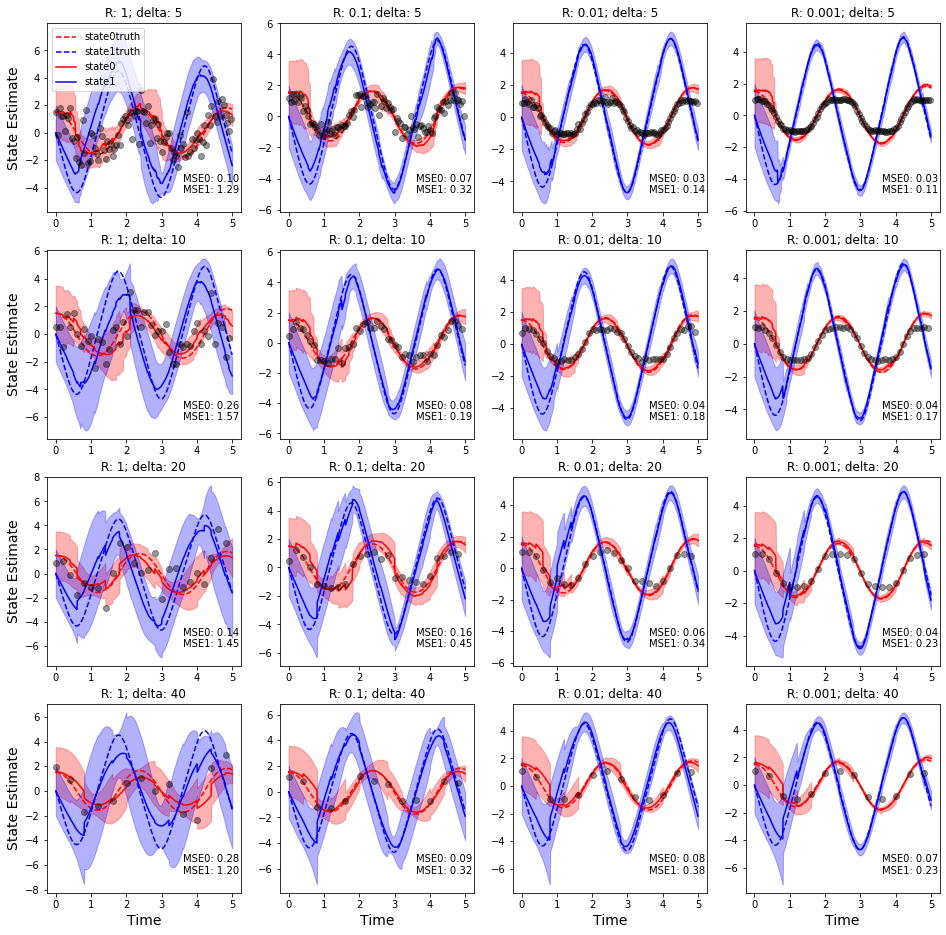

In [69]:
UKF_mean_post = np.zeros((16, Nsims+1, 2))
UKF_cov_post = np.zeros((16, 2, 2, Nsims+1))

plt.figure(figsize=(16,16))

i = 1
t = np.linspace(0, Dt*Nsims, Nsims+1)

for delta in [5, 10, 20, 40]:
    for R in [1, 0.1, 0.01, 0.001]:
        ax = plt.subplot(4, 4, i)
        
        x0 = np.array([1.5, 0])
        xout, yout = generate_truth(Nsims, x0, h, Phi, noise_std=np.sqrt(R))
        
        prior_mean = np.copy(x0) # prior mean
        prior_cov = np.eye(2)  # prior covariance
        proc_cov = np.array([[qc * (Dt)**3 / 3, qc * (Dt)**2 / 2], [qc * (Dt)**2 / 2, qc * (Dt)]])
        meas_cov = np.copy(R)
        
        meanpost, covpost = unscented_kalman_filter(yout, Phi, proc_cov, h, meas_cov, prior_mean, prior_cov)
        UKF_mean_post[i-1, :, :] = meanpost
        UKF_cov_post[i-1, :, :, :] = covpost
        
        std_devs = get_std(covpost) #extract the standard deviations at all the states
        
        ax.plot(t, xout[:, 0],'--', color='red', label='state0truth')
        ax.plot(t, xout[:, 1],'--', color='blue', label='state1truth')

        ax.plot(t, meanpost[:, 0], color='red', label='state0')
        ax.plot(t, meanpost[:, 1], color='blue', label='state1') 
        ax.fill_between(t, meanpost[:, 0] - 2 * std_devs[:, 0],  meanpost[:, 0] + 2*std_devs[:, 0],
                        color='red', alpha=0.3)
        ax.fill_between(t, meanpost[:, 1] - 2 * std_devs[:, 1],  meanpost[:, 1] + 2*std_devs[:, 1],
                        color='blue', alpha=0.3)
        
        MSE0 = np.sum((meanpost[:, 0] - xout[:, 0])**2)/Nsims##
        MSE1 = np.sum((meanpost[:, 1] - xout[:, 1])**2)/Nsims##
        tex = "MSE0: {:.2f}\nMSE1: {:.2f}".format(MSE0, MSE1) 
        ax.text(0.7, 0.1, tex, transform=ax.transAxes)
        
        for ii in range(1, Nsims+1, delta):
            plt.plot(t[ii], yout[ii, 0], 'ko', alpha=0.4)
            
        if R==1 and delta==5:##
            ax.legend(loc=2)##
        
        if delta==40:
            ax.set_xlabel('Time', fontsize=14)
        
        if R==1:
            ax.set_ylabel('State Estimate',fontsize=14)
            
        ax.set_title('R: ' + str(R) + '; delta: ' + str(delta))
        
        i += 1
        
plt.show()

## Gauss-hermite Kalman Filter (GHKF)

Similar to UKF, Gauss-Hermite Kalman Filter (GHKF) consists of three steps as well: quadrature points generation, prediction, and update. The goal of this algorithm is to achieve the following approximation:
\begin{equation}
    \int{h(u)p(u)du} \approx \int{\sum_{i=0}^{n} a_i H_i (u) p(u) du = a_0}
\end{equation}
where $H_i$ is the $i$-th order of Hermite polynomial.

#### GHKF: Quadrature Points Generation
The quadrature points are generated by Golub-Welsch algorithm. The Hermite polynomials can be found from the recursion:
\begin{equation}
    H_{k+1}(x) = a_{k+1}xH_k(x) - c_{k+1}H_{k-1}(x) = xH_k(x) - kH_{k-1}(x)
\end{equation}
we have $a_{k+1} = 1$, $c_{k+1} = k$ (i.e. $c_{k} = k-1$). Then the symmetric tridiagonal matrix $J_{N\times N}$ is formed:
\begin{equation}
    J_{N\times N} = 
    \begin{bmatrix}
        0 & \beta_1 & 0\\
        \beta_1 & 0 & \beta_2 & 0\\
        0 & \beta_2 & 0 & \beta_3 & ...\\
          &         &   & ... & ... &  \\
          &         &   &         & 0 & \beta_{N-1}\\
          &         &   &         &\beta_{N-1} & 0
    \end{bmatrix}
\end{equation}
where $\beta_i = \sqrt{\frac{c_{i+1}}{a_i a_{i+1}}}$. Taking the eigenvalue decomposition of this matrix. The eigenvalues are the quadrature points, and the square of the first element of each orthonormal eigenvector is the weight for the Hermite polynomials.

In [70]:
def gh_oned(num_pts=2):
    """Gauss-hermite quadrature in 1D"""
    A = np.zeros((num_pts, num_pts))
    for ii in range(num_pts):
        #print("ii ", ii, ii==0, ii==(order-1))
        row = ii+1
        if ii == 0:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
        elif ii == (num_pts-1):
            A[ii-1, ii] = np.sqrt(ii)
        else:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
    pts, evec = np.linalg.eig(A)
    devec = np.dot(evec.T, evec)
    wts = evec[0,:]**2
    
    return pts, wts

def tensorize(nodes):
    """Tensorize nodes to obtain twod"""
    n1d = nodes.shape[0]
    twodnodes = np.zeros((n1d*n1d, 2))
    ind = 0
    for ii in range(n1d):
        for jj in range(n1d):
            twodnodes[ind, :] = np.array([nodes[ii], nodes[jj]])
            ind +=1
    return twodnodes

def gauss_hermite(dim, num_pts=2):
    """Gauss-hermite quadrature in 2D"""
    assert dim == 2, "Tensorize only implemented for dim=2"
    pts, weights = gh_oned(num_pts)
    ptsT = tensorize(pts)
    weightsT = tensorize(weights)
    weightsT = np.prod(weightsT, axis=1)
    return ptsT, weightsT

def rotate_points(points, mean, cov, alg="chol"):
    """Rotating points from standard gaussian to target Gaussian"""
    if alg == "chol":
        L = np.linalg.cholesky(cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(cov)
        L = np.dot(u, np.sqrt(np.diag(s)))
        

    new_points = np.zeros(points.shape)
    for ii in range(points.shape[0]):
        new_points[ii, :] = mean + np.dot(L, points[ii,:].T)
    return new_points

#### GHKF: Prediction Step
The sigma points $\xi^{(i)}$ and corresponding weights $w^{(i)}$ are generated based on previous step $X_{k-1}$ and previous covariance $C_{k-1}$:
\begin{equation}
    X_{k-1}^{(i, \sigma)} = X_{k-1} + \sqrt{C_{k-1}} \xi^{(i)}
\end{equation}
we have 
\begin{equation}
    m_k^- = \sum_{i=0}^{m} w^{(i)} \Phi(X_{k-1}^{(i, \sigma)})
\end{equation}
and
\begin{equation}
    C_k^- = \sum_{i=0}^{m}w^{(i)}\Phi(X_{k-1}^{(i, \sigma)}) \Phi(X_{k-1}^{(i, \sigma)})^T - m_k^- {m_k^-}^T + \mathbf{Q}
\end{equation}

In [71]:
def gauss_hermite_prediction_step(Phi, mean, cov, noise_cov, GHP, W):
    """Prediction Step (GHKF): Propagate uncertainty for one time step using gauss hermite Kalman Filter

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{0, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    Phi: callable, non-linear system
    mean: (d, ) prior mean
    cov: (d, d) prior covariance, symmetric positive definite
    noise_cov: (d, d) process noise covariance, symmetric positive definite
    GHP: ghu points points
    W: weights

    Returns
    -------
    pred_mean: (d, ) predicted mean
    pred_cov: (d, d) predicted covariance
    UP_Phi: Phi of Unscented Points
    """
    
    n_GHP = GHP.shape[0]
    dim = cov.shape[0]
    GHP_Phi = np.zeros((GHP.shape)) # Phi of sigma points 
    pred_mean = np.zeros((2))
    
    for ii in range(n_GHP):        
        GHP_Phi[ii, :] = Phi(GHP[ii, :])
        pred_mean += W[ii] * GHP_Phi[ii, :]
    
    delta = GHP_Phi - pred_mean
    
    pred_cov = np.zeros((dim, dim))
    for ii in range(n_GHP):
        pred_cov += W[ii] * np.dot(GHP_Phi[ii, :][:, np.newaxis], GHP_Phi[ii, :][np.newaxis, :])
    pred_cov += noise_cov
    pred_cov -= np.dot(pred_mean[:, np.newaxis], pred_mean[np.newaxis, :])
    
    return pred_mean, pred_cov, GHP_Phi

#### GHKF: Update Step

Evaluate the quadrature points:
\begin{equation}
    X_{k}^{(i, \sigma)} = m_{k}^- + \sqrt{C_{k}^-} \xi^{(i)}
\end{equation}
then we can obtain the following equations.
\begin{equation}
    \mu = \sum_{i=0}^{m}w^{(i)} h(X_{k}^{(i, \sigma)})
\end{equation}
\begin{equation}
    U = \sum_{i=0}^{m}w^{(i)} X_{k}^{(i, \sigma)} h(X_{k}^{(i, \sigma)})^T  - m_k^-\mu^T
\end{equation}
\begin{equation}
    S = \sum_{i=0}^{m}w^{(i)} h(X_{k}^{(i, \sigma)}) h(X_{k}^{(i, \sigma)})^T - \mu \mu^T + r^{\delta k}
\end{equation}
\begin{equation}
    m_k = m_k^- + US^{-1}(y_k - \mu)
\end{equation}
\begin{equation}
    C_k = C_k^- - US^{-1}U^T
\end{equation}

In [72]:
def gauss_hermite_update_step(data, h, mean, cov, noise_cov, GHP, W, GHP_Phi):
    """Update Step (GHKF)
    
    Inputs
    ------
    data: (d,)
    h: callable, measurement function
    mean: (d) prior mean
    cov: (d, d) prior covariance
    noise_cov : (d, d) noise covariance matrix
    UP: unscented points
    W: weights
    GHP_Phi: Phi of gauss hermite Points
    
    Returns
    -------
    update_mean: (d, ) updated mean
    update_cov: (d, d) updated covariance
    
    """
    dim = cov.shape[0]
    n_GHP = GHP_Phi.shape[0]
    
    GHP_h = np.zeros(GHP.shape)
    
    for ii in range(n_GHP):
        GHP_h[ii, :] = h(GHP[ii, :])
        
    GHP_h = GHP_h[:, 0]
    
    mu = 0
    for ii in range(n_GHP):
        mu += W[ii] * GHP_h[ii]
    
    #delta = GHP_Phi_h[:, 0] - mu[0]
    
    S = 0
    for ii in range(n_GHP):
        S += W[ii] * GHP_h[ii] * GHP_h[ii]
    S += noise_cov
    S -= mu * mu
    
    # deltaX = GHP_Phi - mean
    
    GHP_mean = np.mean(GHP, axis=0)
    
    U = np.zeros((dim, 1))
    for ii in range(n_GHP):
        U += W[ii] * GHP[ii, :][:, np.newaxis] * GHP_h[ii]
    U -= GHP_mean[:, np.newaxis] * mu
    
    update_mean = mean[:, np.newaxis] + U / S * (data[0] - mu)
    update_mean = np.reshape(update_mean, 2)
    update_cov = cov - np.dot(U/S, U.T)
    
    return update_mean, update_cov

#### Gauss-Hermite Kalman Filter Routine

In [73]:
def gauss_hermite_kalman_filter(data, Phi, proc_cov, h, meas_cov, prior_mean, prior_cov):
    """The gauss hermite Kalman filter
    
    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    Phi: callable, non-linear system
    proc_cov: (d,d), process noise covariance
    h: callable, measurement function
    meas_cov: (m, m), measurement noise covariance
    prior_mean: (d, ) prior mean
    prior_cov: (d, d), prior_covariance
    
    Return
    ------
    mean_store: (N+1, d): posterior means (first row is the prior)
    cov_store: (d, d, N+1): posterior covariances (first block is the prior)    
    """
    
    d = prior_mean.shape[0]
    N = data.shape[0]
    m = data.shape[1]
    
    mean_store = np.zeros((N+1, d))
    mean_store[0, :] = np.copy(prior_mean)
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    GHPs, W = gauss_hermite(2, num_pts=3)
    #Loop over all data
    for ii in range(N):
        
        # GH points & parameters
        GHP = rotate_points(GHPs, mean_store[ii, :], cov_store[:, :, ii], alg="chol")
        
        # Prediction
        pred_mean, pred_cov, GHP_Phi = gauss_hermite_prediction_step(Phi, mean_store[ii, :], cov_store[:, :, ii], proc_cov, GHP, W)

        # Update
        if ii % delta != 0:
            mean_store[ii+1, :] = pred_mean
            cov_store[:, :, ii+1] = pred_cov
        elif ii % delta == 0:
             # GH points & parameters
            GHP = rotate_points(GHPs, pred_mean, pred_cov, alg="chol")
            mean_store[ii+1, :], cov_store[:, :, ii+1] = gauss_hermite_update_step(data[ii, :], h, pred_mean, pred_cov, meas_cov, GHP, W, GHP_Phi)
    return mean_store, cov_store

#### Run GHKF

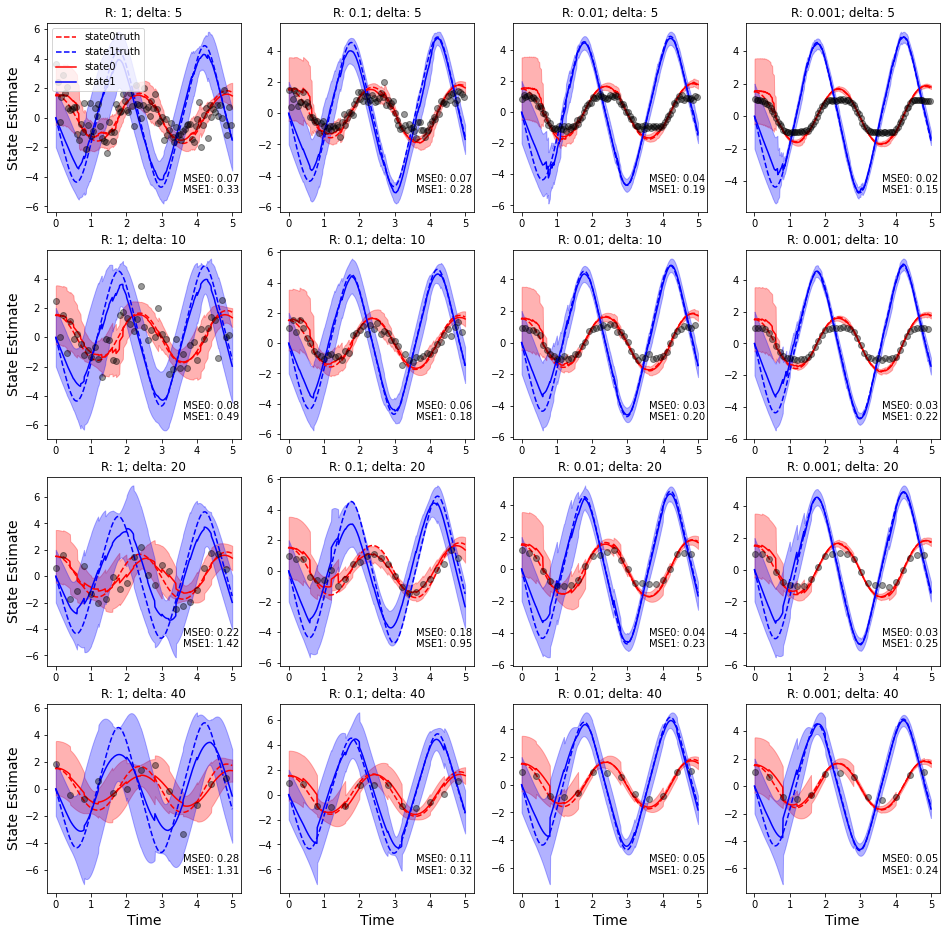

In [82]:
GHKF_mean_post = np.zeros((16, Nsims+1, 2))
GHKF_cov_post = np.zeros((16, 2, 2, Nsims+1))

plt.figure(figsize=(16,16))

i = 1
t = np.linspace(0, Dt*Nsims, Nsims+1)

for delta in [5, 10, 20, 40]:
    for R in [1, 0.1, 0.01, 0.001]:
        ax = plt.subplot(4, 4, i)
        
        x0 = np.array([1.5, 0])
        xout, yout = generate_truth(Nsims, x0, h, Phi, noise_std=np.sqrt(R))
        
        prior_mean = np.copy(x0) # prior mean
        prior_cov = np.eye(2)  # prior covariance
        proc_cov = np.array([[qc * (Dt)**3 / 3, qc * (Dt)**2 / 2], [qc * (Dt)**2 / 2, qc * (Dt)]])
        meas_cov = np.copy(R)
        
        meanpost, covpost = gauss_hermite_kalman_filter(yout, Phi, proc_cov, h, meas_cov, prior_mean, prior_cov)
        GHKF_mean_post[i-1, :, :] = meanpost
        GHKF_cov_post[i-1, :, :, :] = covpost
        
        std_devs = get_std(covpost) #extract the standard deviations at all the states
        
        ax.plot(t, xout[:, 0],'--', color='red', label='state0truth')
        ax.plot(t, xout[:, 1],'--', color='blue', label='state1truth')

        ax.plot(t, meanpost[:, 0], color='red', label='state0')
        ax.plot(t, meanpost[:, 1], color='blue', label='state1') 
        ax.fill_between(t, meanpost[:, 0] - 2 * std_devs[:, 0],  meanpost[:, 0] + 2*std_devs[:, 0],
                        color='red', alpha=0.3)
        ax.fill_between(t, meanpost[:, 1] - 2 * std_devs[:, 1],  meanpost[:, 1] + 2*std_devs[:, 1],
                        color='blue', alpha=0.3)
        
        MSE0 = np.sum((meanpost[:, 0] - xout[:, 0])**2)/Nsims
        MSE1 = np.sum((meanpost[:, 1] - xout[:, 1])**2)/Nsims
        tex = "MSE0: {:.2f}\nMSE1: {:.2f}".format(MSE0, MSE1) 
        ax.text(0.7, 0.1, tex, transform=ax.transAxes)

        
        for ii in range(1, Nsims+1, delta):
            plt.plot(t[ii], yout[ii, 0], 'ko', alpha=0.4)
        
        if R==1 and delta==5:
            ax.legend(loc=2)
        
        if delta==40:
            ax.set_xlabel('Time', fontsize=14)
        
        if R==1:
            ax.set_ylabel('State Estimate',fontsize=14)
            
        ax.set_title('R: ' + str(R) + '; delta: ' + str(delta))
        
        i += 1
        
plt.show()

## Performance Comparison
#### Robustness
The following codes show the squared deviation between the filtered values and the truth values. Judging from this figure, the lower the update rate (i.e. higher $\delta$) with higher noise covariance (i.e. the bottom-left panels), the more likely that the filtered values mismatch the truth. Taking the most unfriendly situation as an example ($R=1$, $\delta=40$), the ExKF is significantly unstable with respect to others. The GHKFs seems to be more stable and robust in this situation.

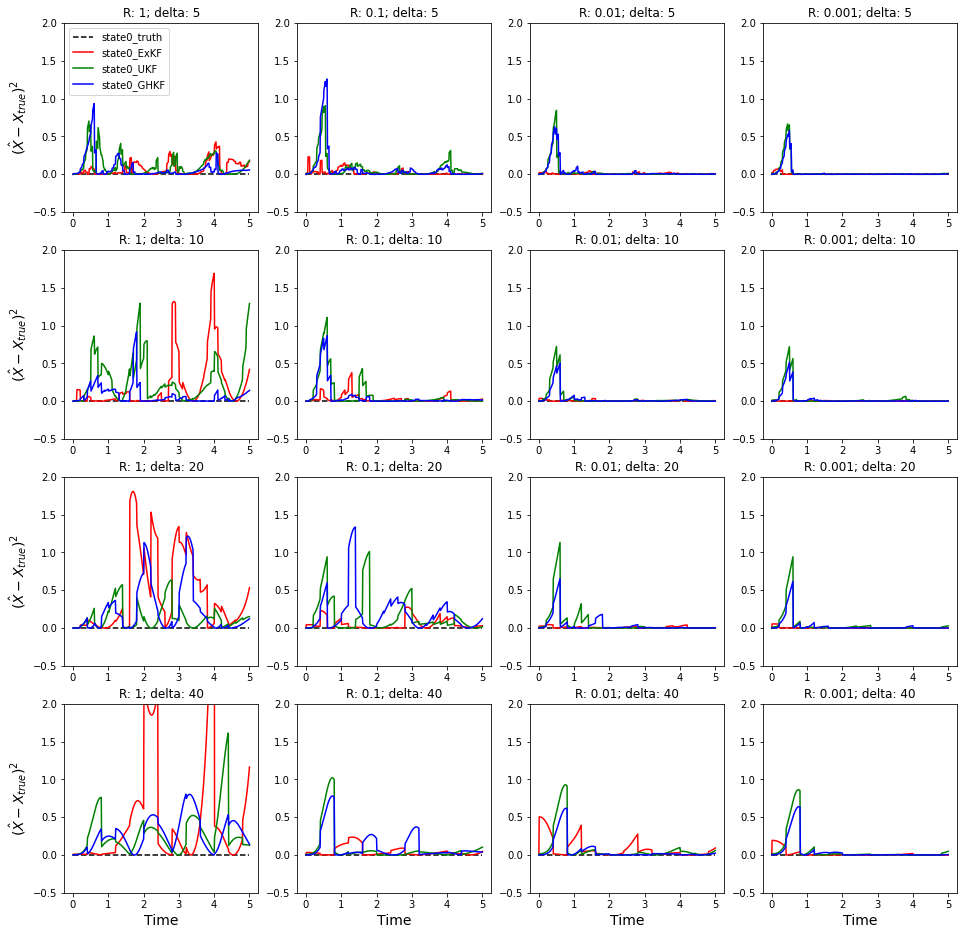

In [83]:
plt.figure(figsize=(16,16))

i = 1
t = np.linspace(0, Dt*Nsims, Nsims+1)

for delta in [5, 10, 20, 40]:
    for R in [1, 0.1, 0.01, 0.001]:
        ax = plt.subplot(4, 4, i)
        
        x0 = np.array([1.5, 0])
        xout, yout = generate_truth(Nsims, x0, h, Phi, noise_std=np.sqrt(R))
        
        ax.plot(t, xout[:, 0] - xout[:, 0],'--', color='k', label='state0_truth')
        ax.plot(t, (ExKF_mean_post[i-1, :, 0] - xout[:, 0])**2, color='r', label='state0_ExKF')
        ax.plot(t, (UKF_mean_post[i-1, :, 0] - xout[:, 0])**2, color='g', label='state0_UKF')
        ax.plot(t, (GHKF_mean_post[i-1, :, 0] - xout[:, 0])**2, color='b', label='state0_GHKF')
        
        
        if R==1 and delta==5:
            ax.legend(loc=2)
        
        if delta==40:
            ax.set_xlabel('Time', fontsize=14)
        
        if R==1:
            ax.set_ylabel(r'$(\hat{X} - X_{true})^2$',fontsize=14)
            
        ax.set_title('R: ' + str(R) + '; delta: ' + str(delta))
        ax.set_ylim(-0.5, 2)
        
        i += 1